In [1]:
import sys
sys.path.append("../")
import matplotlib.pyplot as plt

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np

# Look at data

In [3]:
Xad = sc.read_h5ad("../../Data/echidna3/Tumor2_X.h5ad")
Xad

AnnData object with n_obs × n_vars = 2337 × 27762
    obs: 'celltypes', 'celltypes_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'celltypes_RNA_colors', 'celltypes_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
Wdf = pd.read_csv("../../Data/echidna3/Tumor2_W.csv")
Wdf.set_index("Unnamed: 0", inplace=True)
Wdf.index.name = "gene"
Wdf.head()

,0
gene,
A3GALT2,10.522400
AADACL3,12.252164
AADACL4,12.252164
ABCA4,11.080183
ABCB10,11.838389


In [5]:
DNA = pd.read_csv("../../Data/echidna3/DNA_bin_counts_matrix.txt", sep='\t')

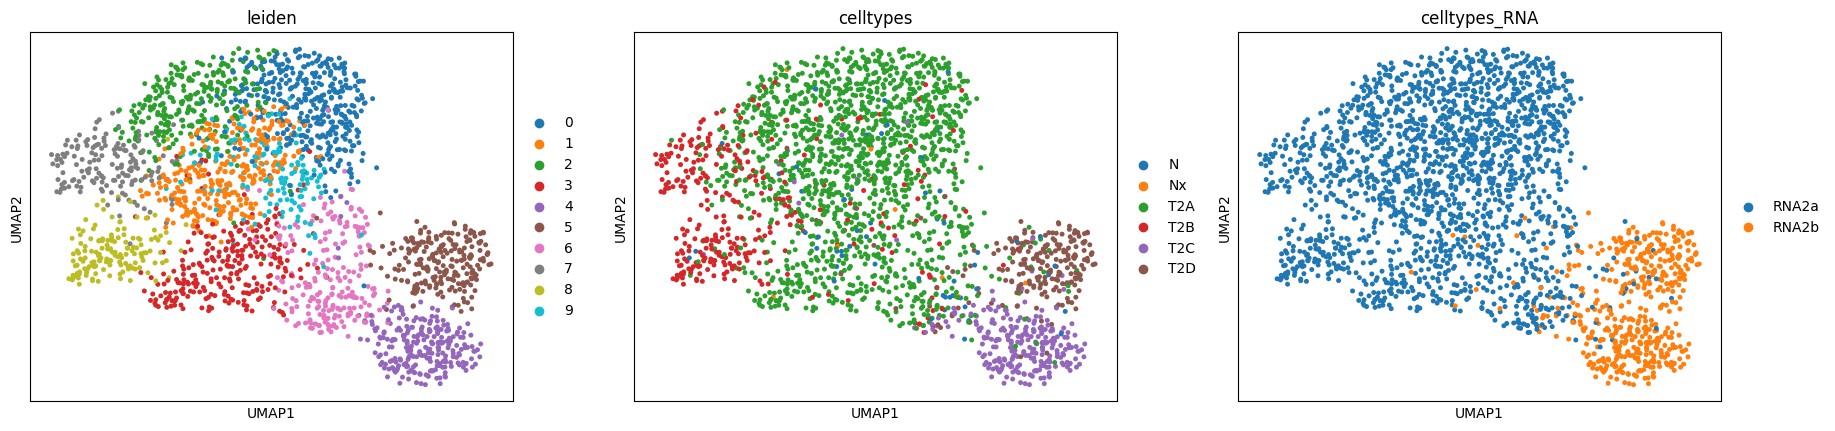

In [6]:
sc.pl.umap(Xad, color=['leiden', 'celltypes',"celltypes_RNA"])

In [7]:
from echidna.utils import *

/Users/mingxuanzhang/Desktop/echidna3/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# fix timepoints as ['st'] for all single timepoint models
# n_subsamples is not used for ST models
X_obs, W_obs, z_obs, pi_obs = prepare_input(Xad, Wdf, sample_name=None, 
                                            timepoints=['st'], n_subsamples=3000, device="cpu")
print(X_obs.shape)
print(W_obs.shape)
print(z_obs.shape)
print(pi_obs.shape)

torch.Size([2337, 27762])
torch.Size([27762])
torch.Size([2337])
torch.Size([10])


# Train Model

In [9]:
from echidna.model import Echidna
from echidna.train import train_Echidna
from echidna.utils import ModelConfig
from echidna.eval import get_learned_params

In [10]:
config = ModelConfig()
config.num_cells = X_obs.shape[1]
config.num_genes = X_obs.shape[-1]
config.num_clusters = pi_obs.shape[0]
config.q_corr_init = 0.1
config.q_shape_rate_scaler = 10.0
config.eta_mean_init = 11.0
config.lkj_concentration = 0.5

In [11]:
echidna = Echidna(config, mode='ST', device='cpu')

In [69]:
echidna, losses = train_Echidna(echidna, X_obs, W_obs, pi_obs, z_obs, lr=0.1, n_epochs=200)

100%|██████████| 200/200 [01:21<00:00,  2.46it/s]


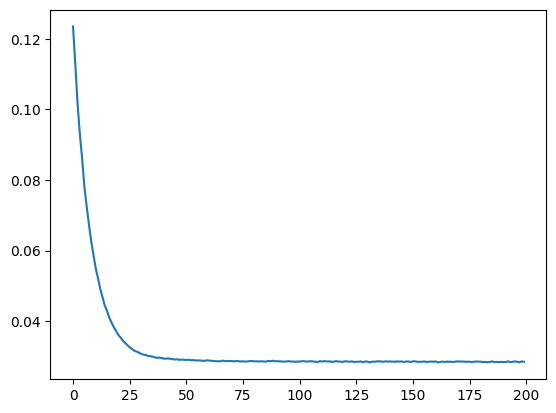

In [70]:
plt.plot(losses)

In [71]:
params = get_learned_params(echidna, X_obs, W_obs, pi_obs, z_obs)

# Analysis

In [72]:
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

In [73]:
c = params['c']['value']
eta = F.softplus(params['eta']['value']).T

In [74]:
from echidna.eval import sample_W, sample_X, plot_true_vs_pred

In [75]:
library_size = X_obs.sum(-1, keepdim=True) * 1e-5

In [76]:
X_learned = sample_X(X_obs.numpy(), c, eta, z_obs.numpy(), library_size)
X_learned.shape

(2337, 27762)

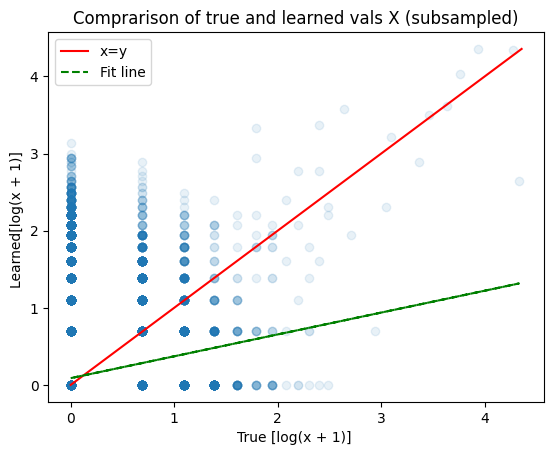

In [77]:
plot_true_vs_pred(X_learned, X_obs.numpy(), log_scale=True, name='X')

In [78]:
W_learned = np.array(sample_W(pi_obs, eta)).reshape(-1, 1)
W_obs_np = W_obs.numpy().reshape(-1, 1)
W_obs_np.shape

(27762, 1)

In [79]:
W_learned.shape

(27762, 1)

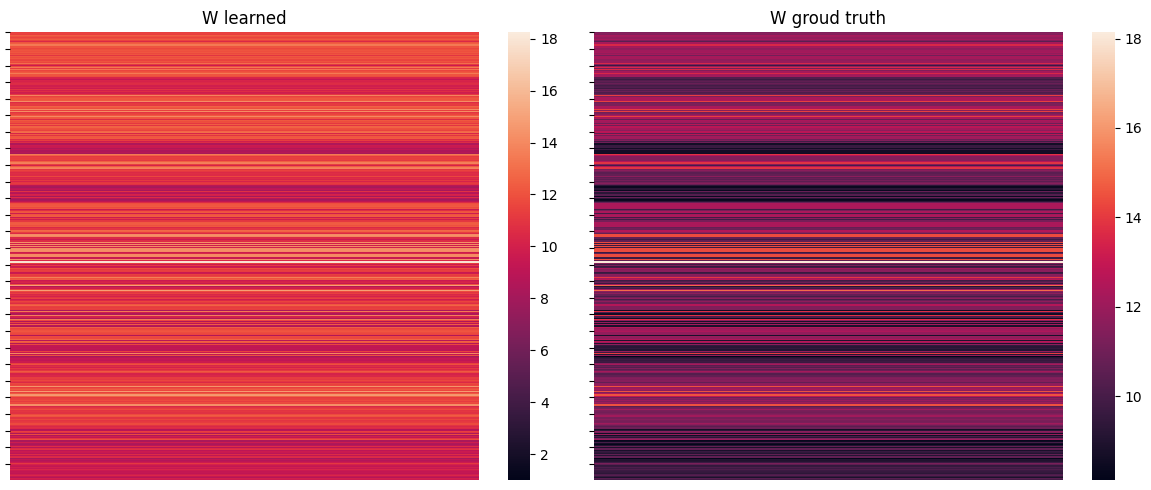

In [80]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first heatmap
sns.heatmap(W_learned, ax=axes[0], vmin=1)
axes[0].set_title('W learned')
axes[0].set_xticks([])
axes[0].set_yticklabels([])

# Plot the second heatmap
sns.heatmap(W_obs_np, ax=axes[1])
axes[1].set_title("W groud truth")
axes[1].set_xticks([])
axes[1].set_yticklabels([])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

<Figure size 100x100 with 0 Axes>

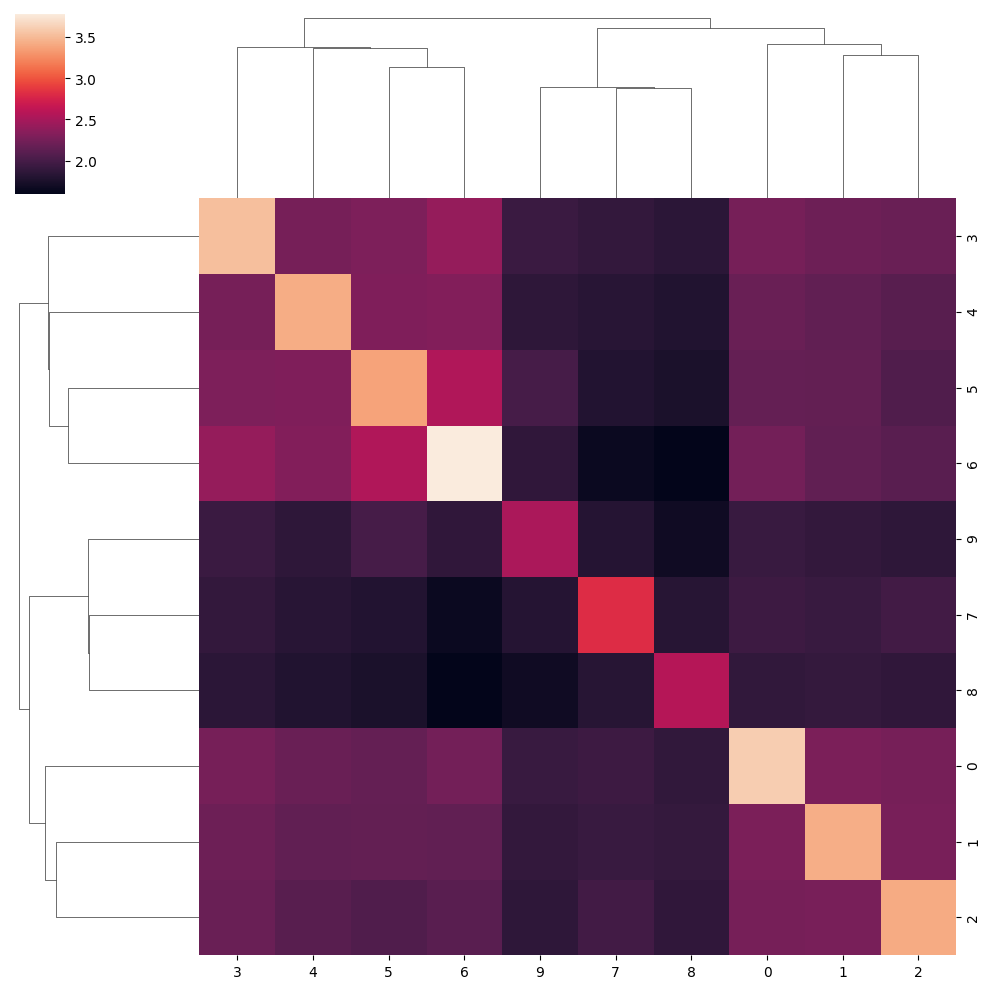

In [81]:
plt.figure(figsize=(1, 1)) 
sns.clustermap(torch.cov(eta).cpu().detach().numpy())
plt.show()

In [82]:
from echidna.eval import eta_cov_tree, assign_clones, learned_cov

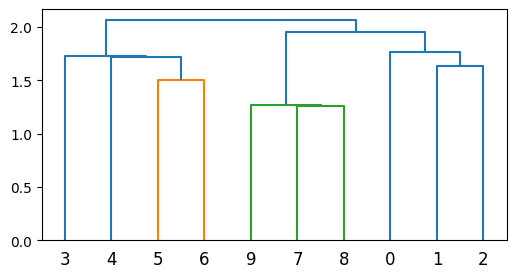

In [84]:
dn = eta_cov_tree(eta, 1.5)

In [85]:
assign_clones(dn, Xad)

/Users/mingxuanzhang/Desktop/echidna3/notebooks/../echidna/eval.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hier_colors = [color_dict.loc[int(i)][0] for i in X.obs["leiden"]]


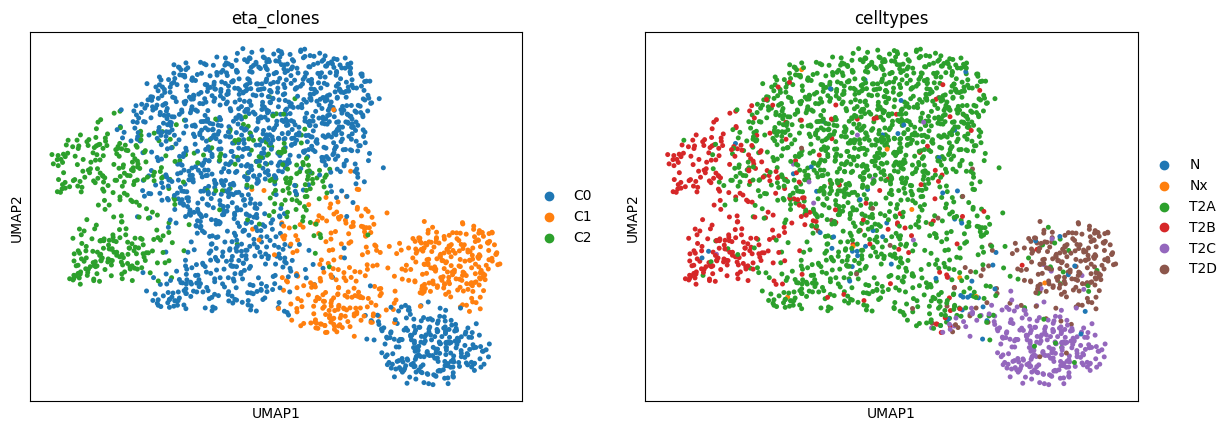

In [86]:
sc.pl.umap(Xad, color=['eta_clones', 'celltypes'])